# Import Dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output as cls
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import (Input, InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout,
                                     MaxPooling2D,Dense,Resizing,Rescaling, Flatten, Layer, Add, Activation,
                                     RandomRotation, RandomFlip, RandomContrast, GlobalAveragePooling2D,
                                     Embedding, LayerNormalization, MultiHeadAttention, RandomBrightness)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger
from tensorflow.keras.regularizers import L2, L1

!pip install datasets
!pip install datasets[vision]
cls()

In [2]:
from datasets import load_dataset

ds = load_dataset("garythung/trashnet", split='train')
print(f'\n{ds}')

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]


Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})


In [3]:
!pip install git
!git lfs install
cls()
!git clone https://huggingface.co/datasets/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.97 KiB | 671.00 KiB/s, done.


In [4]:
import zipfile
with zipfile.ZipFile(file='/kaggle/working/trashnet/dataset-resized.zip', mode='r') as zfile:
    zfile.extractall(path = '/kaggle/working')

# PreProcess Dataset

In [5]:
dataset_dir = '/kaggle/working/dataset-resized'
x = 0
CLASS_NAMES = []

for obj in os.listdir(dataset_dir):
    obj_dir = os.path.join(dataset_dir, obj)
    if os.path.isdir(obj_dir):
        CLASS_NAMES.append(obj)
        x+=len(os.listdir(obj_dir))
        print(f'{obj} => {len(os.listdir(obj_dir))}')
print(f'Total Image => {x}')
print(f'Class Image => {CLASS_NAMES}')

cardboard => 403
metal => 410
glass => 501
plastic => 482
trash => 137
paper => 594
Total Image => 2527
Class Image => ['cardboard', 'metal', 'glass', 'plastic', 'trash', 'paper']


**Note**<br>
Data looks imbalanced, i'll use weight class to balancing model learning process

In [6]:
with open('/kaggle/working/labels.txt', mode='w') as labels:
    labels.writelines(CLASS_NAMES)

CONFIGURATION = {
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 224,
    'NUM_CLASSES' : len(CLASS_NAMES),
    'CLASS_NAMES' : CLASS_NAMES
}

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 100,
#     subset = "training",
#     validation_split = CONFIGURATION['VALIDATION']
)

Found 2527 files belonging to 6 classes.


In [8]:
train_dataset = train_data.take(int(len(train_data)*0.8))
val_dataset = train_data.skip(int(len(train_data)*0.8))
print(len(train_dataset))
print(len(val_dataset))

63
16


In [9]:
from tensorflow.keras import layers
# augmentasi data menggunakan layer
augment_layers = tf.keras.Sequential([
    # Rotasi random dari -0.2 sampai +0.2 radian (sekitar -11.5° sampai +11.5°)
    layers.RandomRotation(0.2),
    
    # Flip horizontal
    layers.RandomFlip("horizontal"),
    
    # Flip vertikal
    layers.RandomFlip("vertikal"),
    
    # Zoom random dalam rentang 75-125% dari ukuran asli
    layers.RandomZoom(0.25),
    
    # Translasi random sampai 20% dari dimensi
    layers.RandomTranslation(0.2, 0.2),
    
    # Mengubah brightness (kecerahan) secara random
    layers.RandomBrightness(0.2),
    
    # Mengubah kontras secara random
    layers.RandomContrast(0.2),
])

def augment_layer(image,label):
    return augment_layers(image, training = True), label

# implementasi pada data training
train_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

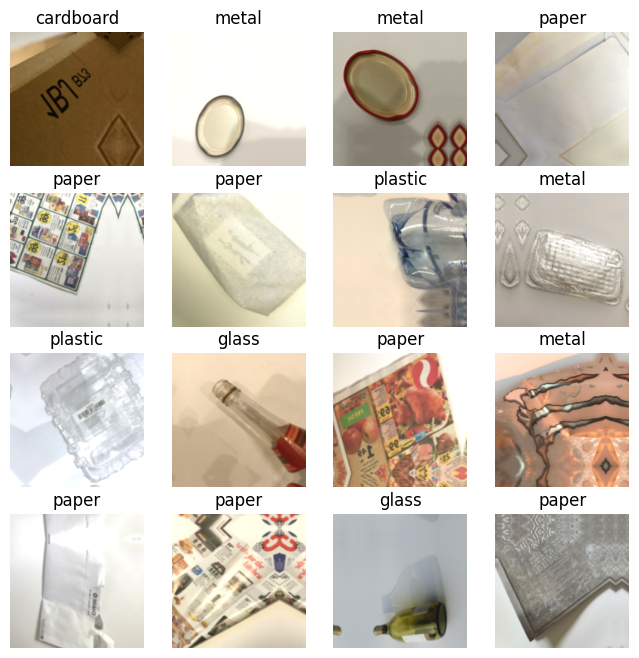

In [10]:
plt.figure(figsize = (8,8))
for image,label in train_dataset:
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/225)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(label[i], axis=0).numpy()])
    plt.axis('off')
plt.show()

In [11]:
def get_labels(data):
    '''
    Args   :
             data : dataset -> prefetch
    return :
             label -> [List]
    '''
    
    file_paths = []
    label = []

    for batch in data:
        images, label_batch = batch
        for i in range(len(label_batch)):
            file_paths.append(images[i])
            label.append(label_batch[i].numpy())  # Convert labels to numpy for better readability
    return label

train_label = get_labels(train_data)
val_label = get_labels(val_dataset)

# Model and Evaluation

## Create Callback

In [12]:
# classes to support training process
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.01,
                               restore_best_weights = True,
                               patience=5)

# early stopping 
class myStop(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.91):
        super(myStop, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy is not None and val_accuracy is not None:
            if accuracy > self.accuracy_threshold and val_accuracy > self.accuracy_threshold:
                print(f"\nEpoch {epoch+1}: accuracy and val_accuracy both reached {self.accuracy_threshold*100}%. Stopping training.")
                self.model.stop_training = True
            
mystop = myStop()

# model checkpoint
check = tf.keras.callbacks.ModelCheckpoint(f'best_model.keras', monitor='val_accuracy', 
                                           save_best_only=True, verbose=0, mode='max')

### WandB Setup

In [13]:
!pip install wandb
cls()

In [14]:
import wandb
wandb.login(key='')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alrezam-amror. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
import wandb
# from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="Adamata-TrashClassification",

    # track hyperparameters and run metadata with wandb.config
    config={
        "activation_output": "softmax",
        "optimizer": "Adam",
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 100,
        "batch_size": 32
    }
)

## Build Model EffNetV2S<br>
i use transfer learning technique because this technique no need large dataset and have low computational cost

In [16]:
backbone = tf.keras.applications.EfficientNetV2S(
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
    include_top=False,
    weights='imagenet',
)
backbone.trainable = False
# cls()

# API Function Method
x = backbone.output
x = GlobalAveragePooling2D(name='GAP2D')(x)
x = Dropout(0.45, name='Dropout1')(x)
# x = BatchNormalization(name='BatchNorm')(x)
output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax', name='Output')(x)
EffNet = Model(
    inputs=backbone.input, 
    outputs=output, 
    name='MobNet'
)

EffNet.compile(
    optimizer = Adam(learning_rate = 0.005),
    loss = CategoricalCrossentropy(),
    metrics = [CategoricalAccuracy(name = 'accuracy')]
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(ds['label']), y=ds['label'])
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

history = EffNet.fit(
    train_dataset, validation_data = val_dataset,
    epochs = 100, verbose = 1, callbacks = [early_stopping, check],
    class_weight = class_weights_dict
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 411ms/step - accuracy: 0.5214 - loss: 1.3883 - val_accuracy: 0.8415 - val_loss: 0.4830
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7724 - loss: 0.6361 - val_accuracy: 0.8454 - val_loss: 0.4598
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.7881 - loss: 0.5783 - val_accuracy: 0.8474 - val_loss: 0.4488
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.7952 - loss: 0.5134 - val_accuracy: 0.8591 - val_loss: 0.4308
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8237 - loss: 0.5059 - val_accuracy: 0.8591 - val_loss: 0.4259
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8352 - loss: 0.4600 - val_accuracy: 0.8376 - val_loss: 0.4521
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.8479 - loss: 0.4658 - val_accuracy: 0.8689 - val_loss: 0.4007
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.8466 - loss: 0.4401 - val_acc

In [18]:
print(f'accuracy train -> {EffNet.evaluate(train_dataset, verbose=0)[1]}')
print(f'loss train -> {EffNet.evaluate(train_dataset, verbose=0)[0]}\n')
print(f'accuracy valid -> {EffNet.evaluate(val_dataset, verbose=0)[1]}')
print(f'loss valid -> {EffNet.evaluate(train_dataset, verbose=0)[0]}\n')

accuracy train -> 0.891865074634552
loss train -> 0.32033440470695496

accuracy valid -> 0.859099805355072
loss valid -> 0.32033440470695496



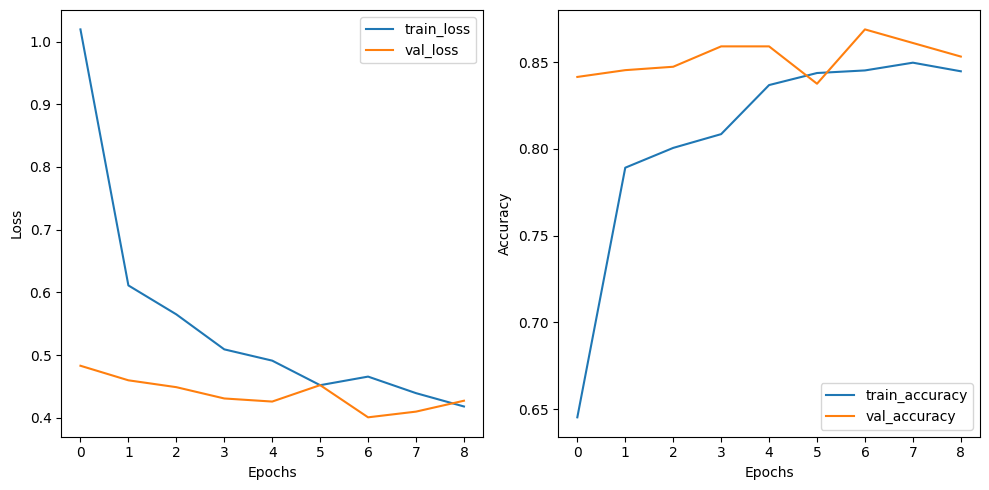

In [19]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

plt.tight_layout()
plt.show()

**Note**<br>
This model can still improve its performance by adding a classification layer and replacing several parameters during the build dan training process

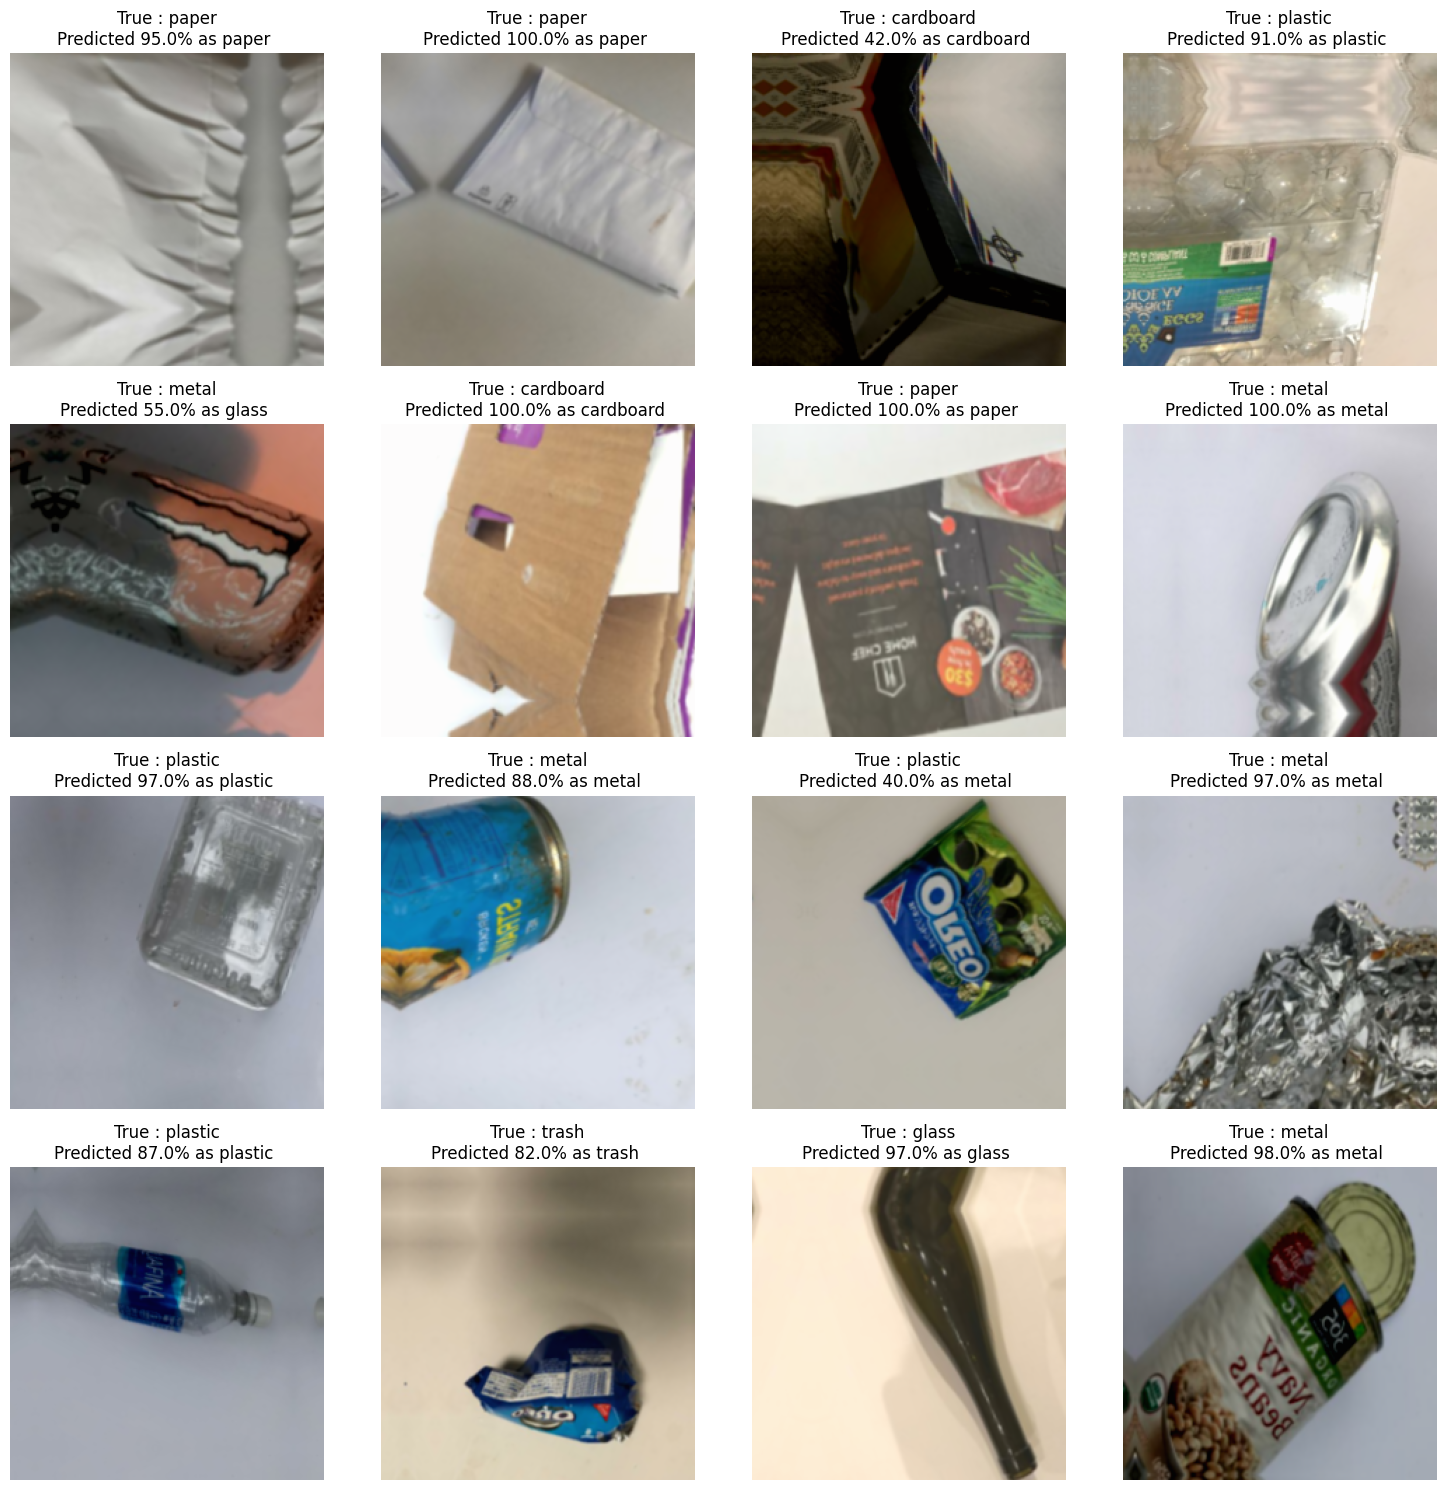

In [20]:
plt.figure(figsize=(15,15))
for image,label in train_dataset.take(1):
  for i in range(16):
    actuall = CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()]
    presentase = round(round(tf.reduce_max(EffNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0], 2)*100, 2)
    pred = CLASS_NAMES[tf.argmax(EffNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0]]
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(f'True : {actuall}\nPredicted {presentase}% as {pred} ')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 702ms/step


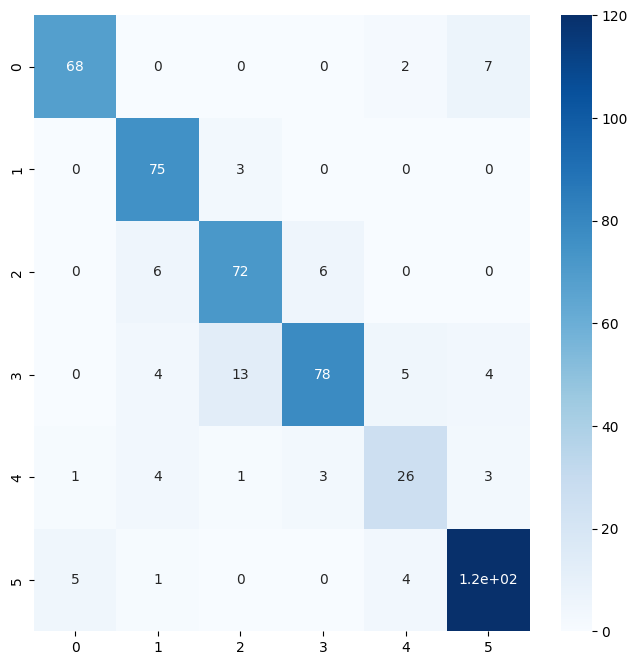

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred = np.argmax(EffNet.predict(val_dataset), axis=1)
actual = np.argmax(get_labels(val_dataset), axis=1)

# Membuat confusion matrix
cm = confusion_matrix(actual, pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.show()

In [23]:
EffNet.save('/kaggle/working/EffNetV2S.h5')
EffNet.save('/kaggle/working/EffNetV2S.keras')
EffNetJSON = EffNet.to_json()
with open(f'/kaggle/working/EffNetV2S.json', mode='w') as writeJSON:
    writeJSON.write(EffNetJSON)